 The pinhole camera model is a very useful piece of mathematics that's going to allow us to establish a mapping between pixels in an image and the points they represent in the world. The pinhole camera models is extremely useful in computer vision, and plays a role in many important problems. One interesting example comes from autonomous driving. Using a series of images and the pinhole camera model, we can make maps:

 I'm going to use the pinhole camera model to project image points on the road surface to make a simple map.
There is one important piece we aren't covering today - to project these points correctly, we need to know the location of our camera as we drive around the track. Here, i'm using data from the high quality IMU in our car. Interestingly, we can also use images to build a map while we simulataneously localize - this process is called SLAM.
In this notebook we'll learn about the mathematics required to make maps like the one shown above.

In [3]:
%pylab inline
import cv2, itertools

Populating the interactive namespace from numpy and matplotlib


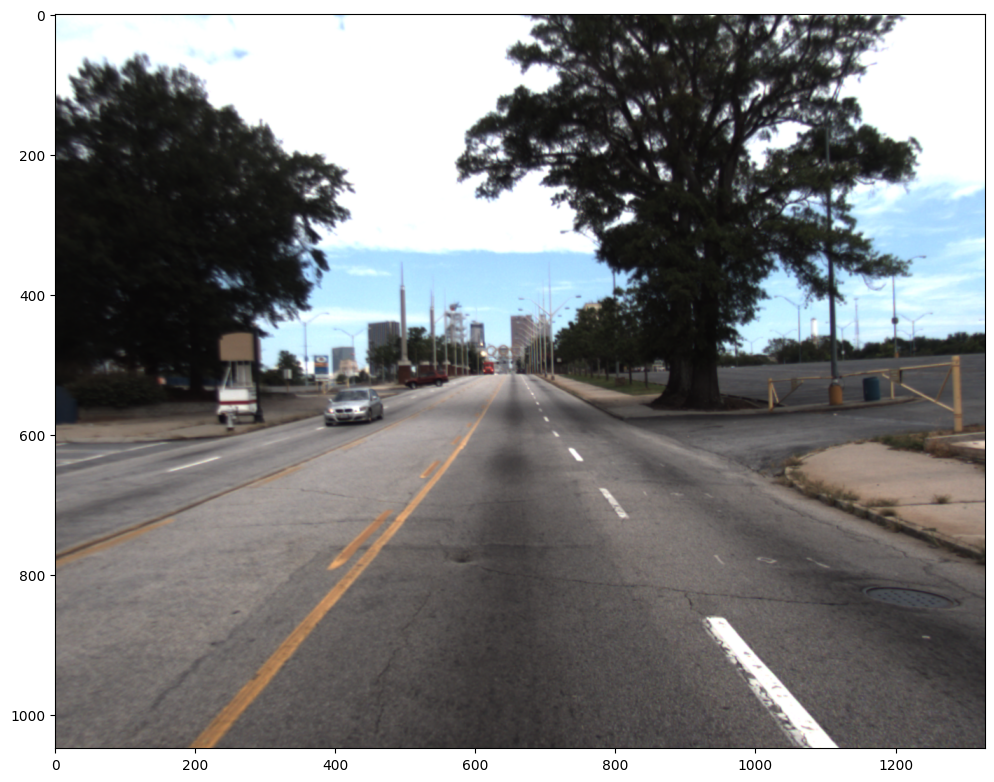

In [4]:
im = cv2.imread('/content/the_3d_world/graphics/track_image.png')
fig = figure(0, (12,12))
imshow(im[:,:,(2,1,0)])

In [5]:
# Extrinsics parameters - this is the relative translation and
# rotation between the camera and rear vehicle axle
tvec = np.array([[0], [1549.], [1750.]], dtype = 'float32')
rvec = np.array([[0.00], [0.03], [0.00]], dtype = 'float32')

In [6]:
#Extrinsic matrix
Omega = np.hstack((cv2.Rodrigues(rvec)[0], tvec))

In [7]:
#Intrinsic Matrix, from checker-board camera calibration
intrinsicP = np.array([[1236.6, 0, 687.8],
                        [0, 1232.9, 544.7],
                        [0, 0, 1]])

In [8]:
#w = 0 effectively removes the second row of our extrtinsic matrix.
# Let's go ahead and multiply our intrinsic and extrinsic matrix
phi = np.dot(intrinsicP, Omega[:,[0,2,3]])

In [9]:
phi

array([[ 1.21541268e+03,  7.24582955e+02,  1.20365000e+06],
       [-1.63385484e+01,  5.44454909e+02,  2.86298710e+06],
       [-2.99954992e-02,  9.99550045e-01,  1.75000000e+03]])

In [10]:
phiInv = np.linalg.inv(phi)

In [11]:
phiInv

array([[ 8.08305049e-04,  2.74862102e-05, -6.00919450e-01],
       [ 2.42564277e-05, -9.15932168e-04,  1.48177470e+00],
       [-1.87835666e-25,  5.23625430e-07, -2.85218771e-04]])

In [12]:
allPixelIndices = np.zeros((im.shape[0]*im.shape[1], 2))

#This is just a cartesian product:
for i, element in enumerate(itertools.product(range(im.shape[1]),
                                              range(im.shape[0]))):
    allPixelIndices[i, :] = element

In [13]:
print(allPixelIndices.shape, allPixelIndices)

(1391744, 2) [[0.000e+00 0.000e+00]
 [0.000e+00 1.000e+00]
 [0.000e+00 2.000e+00]
 ...
 [1.327e+03 1.045e+03]
 [1.327e+03 1.046e+03]
 [1.327e+03 1.047e+03]]


In [14]:
r = im[:,:,0]
g = im[:,:,1]
b = im[:,:,2]

raveledRGB = np.vstack((b.T.ravel(), g.T.ravel(), r.T.ravel())).T

In [15]:
raveledRGB

array([[247, 255, 255],
       [244, 255, 255],
       [242, 255, 255],
       ...,
       [ 76,  79,  77],
       [ 83,  82,  77],
       [ 81,  77,  77]], dtype=uint8)

In [16]:
#Convert to homogeneous coords
allPixelsPadded = np.hstack((allPixelIndices, np.ones((allPixelIndices.shape[0], 1))))

In [17]:
allPixelsPadded

array([[0.000e+00, 0.000e+00, 1.000e+00],
       [0.000e+00, 1.000e+00, 1.000e+00],
       [0.000e+00, 2.000e+00, 1.000e+00],
       ...,
       [1.327e+03, 1.045e+03, 1.000e+00],
       [1.327e+03, 1.046e+03, 1.000e+00],
       [1.327e+03, 1.047e+03, 1.000e+00]])

In [18]:
#Project by multiplying by inverse matrix
worldCoords = np.dot(phiInv, allPixelsPadded.T)

#Convert from homogeneous to cartesian coordinates
worldCoords = worldCoords/worldCoords[2,:]

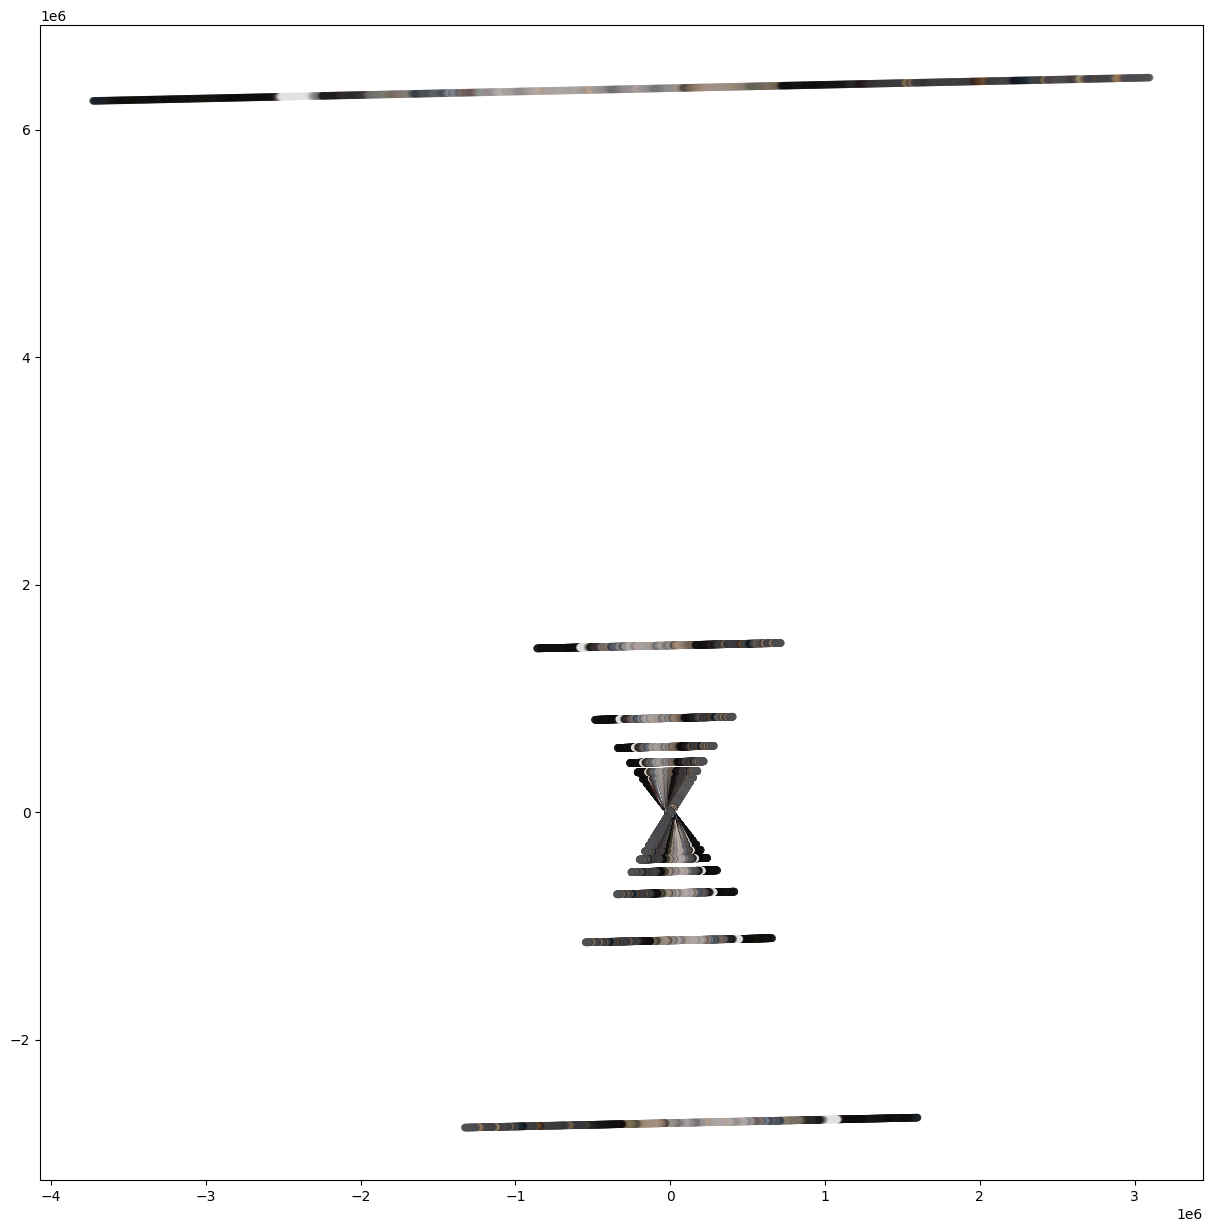

In [19]:
#Let's visualize our projected points - might be a little slow!
fig = figure(0, (15,15))
scatter(worldCoords[0, :], worldCoords[1,:], c = raveledRGB/255., s = 20, alpha = 0.5)

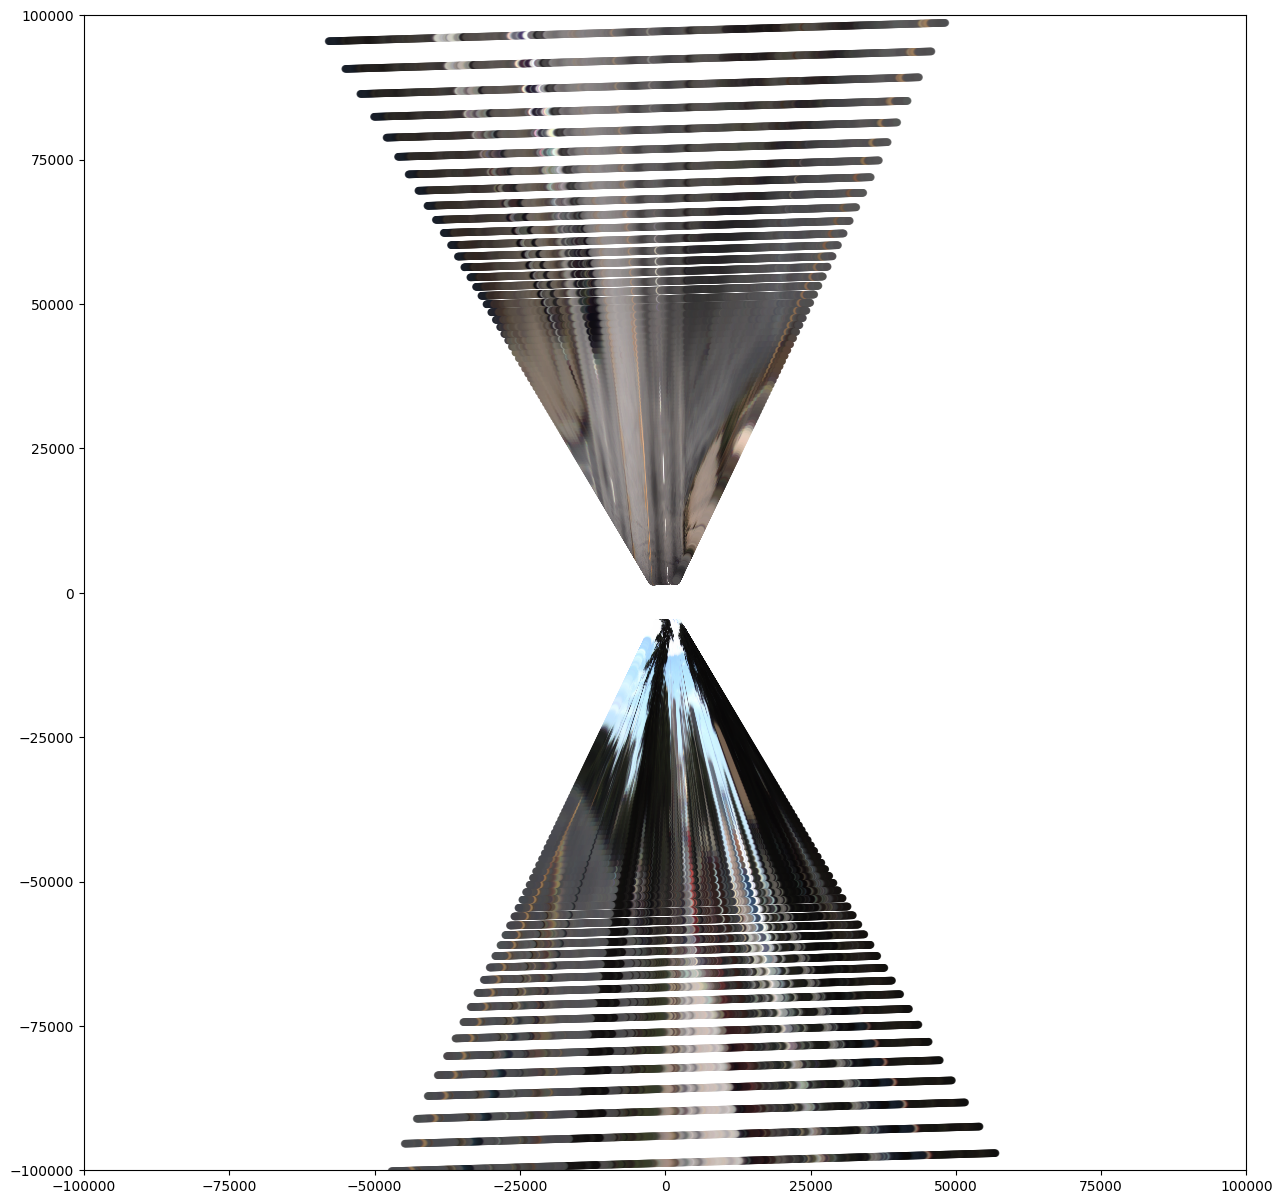

In [20]:
fig = figure(0, (15,15))
scatter(worldCoords[0, :], worldCoords[1,:], c = raveledRGB/255., s = 20, alpha = 0.5)
xlim([-100000, 100000]);
ylim([-100000, 100000]);

In [21]:
minWorldDist = 1.0
maxLookAheadDist = 45.0

indicesToPlot = np.logical_and(worldCoords[1,:] > minWorldDist, worldCoords[1,:]< maxLookAheadDist*1000.)
wC = (worldCoords[:2, indicesToPlot]/1000)

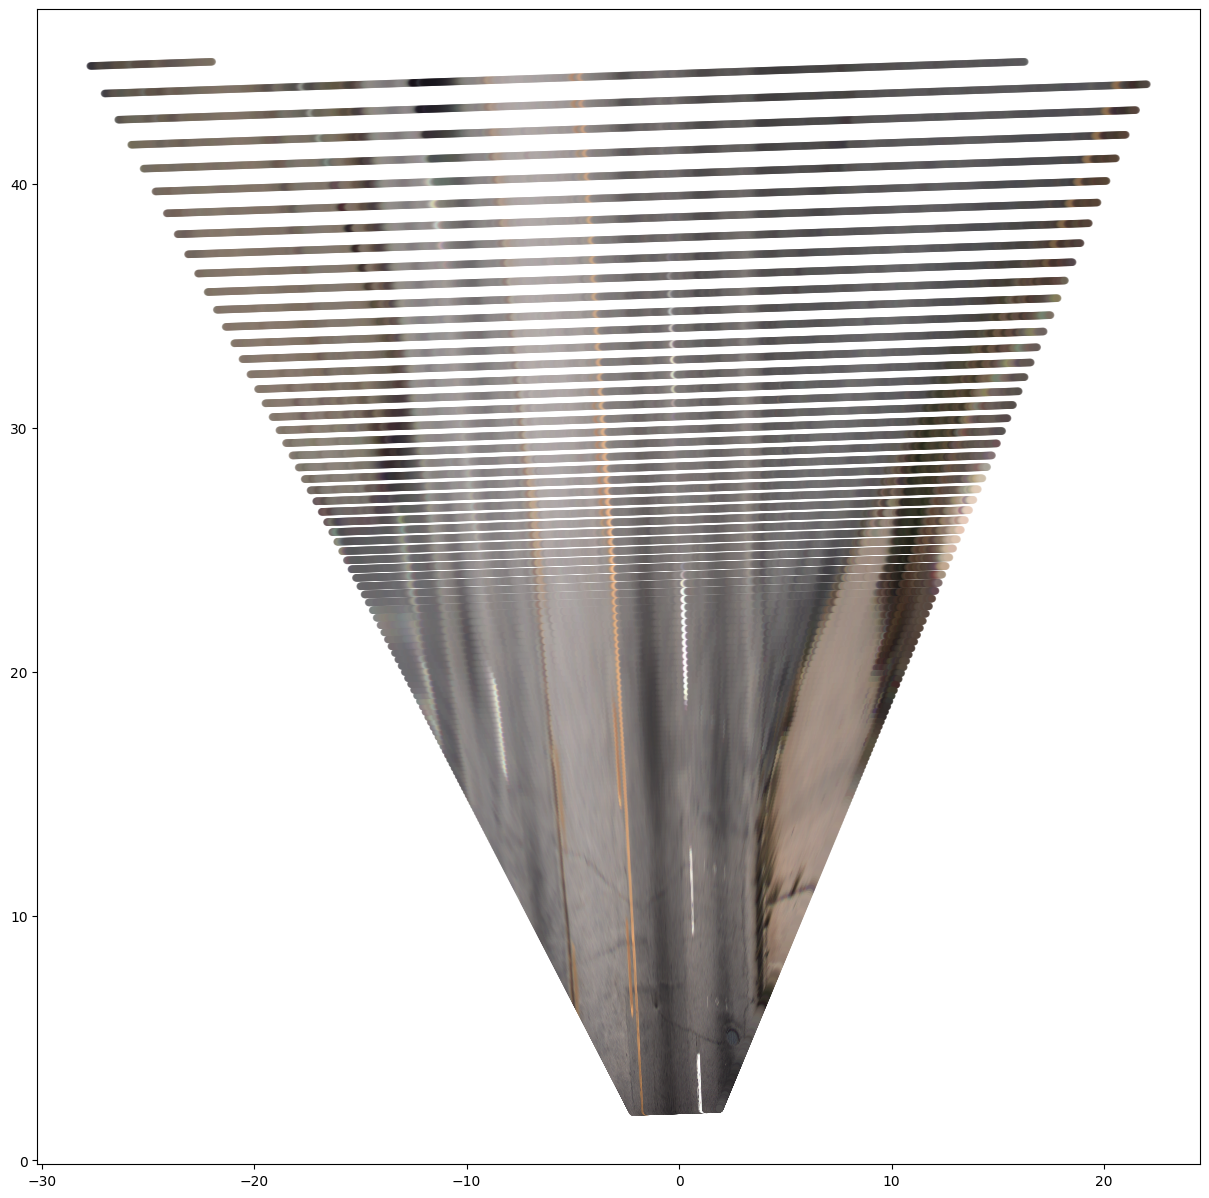

In [22]:
fig = figure(0, (15,15))
scatter(wC[0, :], wC[1,:], c = raveledRGB[indicesToPlot,:]/255., s = 20, alpha = 0.5)